# Causality and Function Approximations

In [476]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.linear_model
import sympy as sp

from IPython.display import display_markdown, Markdown

from chmp.ds import reload

reload('chmp.ds')
from chmp.ds import (
    cached, 
    define,
    loop_over, 
    loop_nest, 
    pd_has_ordered_assign,
    pgm, 
    qlineplot, 
    to_markdown, 
)
from chmp.app.causality import prob

assert pd_has_ordered_assign()

In [465]:
base_graph = (
    pgm()
    .node('Z', r'$Z$', 1.5, 1.75)
    .node('X', r'$X$', 1, 1)
    .node('Y', r'$Y$', 2, 1)
    .edges('Z', 'XY')
    .edges('X', 'Y')
)

In [466]:
subplot_kwargs = dict(
    gridspec_kw=dict(
        top=0.925, bottom=0.075, left=0.01, right=0.99, wspace=0.1,
    ),
)

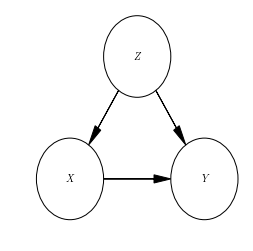

In [467]:
with mpl.rc_context({'text.usetex': True}):
    _, ax1 = plt.subplots(1, 1, figsize=(3, 3.5), **subplot_kwargs)
    base_graph.render(ax=ax1)
    plt.savefig('./blog/schematic.png')

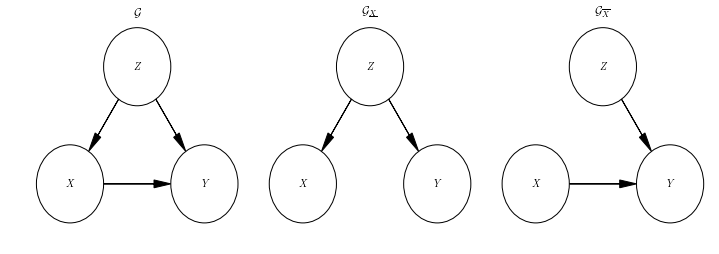

In [468]:
with mpl.rc_context({'text.usetex': True}):
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * (3 + 0.2), 3.35), **subplot_kwargs)
    base_graph.render(ax=ax1, title=r'$\mathcal{G}$')
    base_graph.remove(outgoing='X').render(ax=ax2, title=r'$\mathcal{G}_{\underline{X}}$')
    base_graph.remove(incoming='X').render(ax=ax3, title=r'$\mathcal{G}_{\overline{X}}$')
    plt.savefig('./blog/schematic_graph_operations.png')

## Tabular example

In [461]:
np.random.seed(42_21_13_7)

df = pd.DataFrame().assign(
    z=lambda df: np.random.binomial(n=1, p=0.3, size=100_000),
    x=lambda df: np.random.binomial(n=1, p=0.8 - 0.4 * df['z']),
    y=lambda df: np.random.binomial(n=1, p=0.5 + 0.4 * df['z'] - 0.2 * df['x'])
)
counts = df.groupby(['x', 'y', 'z']).size().pipe(lambda s: s.reorder_levels(sorted(s.index.names)))
reweighted_counts = (0.5 * counts / counts.pipe(prob, 'x', 'z', transform=True)).astype(int)

In [462]:
renames = {
    'x': '`X`',
    'y': '`Y`',
    'z': '`Z`',
}

In [463]:
print(
    pd.concat([
        counts.to_frame("`N`"),
        reweighted_counts.to_frame("`N'`")
    ], axis=1)
    .reset_index()
    .sort_values(['y', 'z', 'x'])
    .rename(columns=renames)
    .pipe(to_markdown)
)

|   `X` |   `Y` |   `Z` |   `N` |   `N'` |
|------:|------:|------:|------:|-------:|
|     0 |     0 |     0 |  6958 |  17407 |
|     1 |     0 |     0 | 39315 |  24567 |
|     0 |     0 |     1 |  1842 |   1536 |
|     1 |     0 |     1 |  3512 |   4385 |
|     0 |     1 |     0 |  7051 |  17640 |
|     1 |     1 |     0 | 16773 |  10481 |
|     0 |     1 |     1 | 16087 |  13415 |
|     1 |     1 |     1 |  8462 |  10566 |


In [9]:
from chmp.app.causality import prob

In [10]:
def _calculuate(c, label):
    return (
        c.pipe(prob, 'y', 'xz')
        .pipe(lambda s: s.xs(1, level='x') - s.xs(0, level='x'))
        .xs(1, level='y')
        .round(3)
        .to_frame(f'`{label}(Y=1/X=1,Z) - {label}(Y=1/X=0,Z)`')
    )

        
print(
    pd.concat([
        _calculuate(counts, "P"),
        _calculuate(reweighted_counts, "P'"),
    ], axis=1)
    .reset_index()
    .rename(columns=renames)
    .pipe(to_markdown)
)

|   `Z` |   `P(Y=1/X=1,Z) - P(Y=1/X=0,Z)` |   `P'(Y=1/X=1,Z) - P'(Y=1/X=0,Z)` |
|------:|--------------------------------:|----------------------------------:|
|     0 |                          -0.204 |                            -0.204 |
|     1 |                          -0.191 |                            -0.191 |


In [11]:
print(
    counts
    .pipe(
        lambda df: (
            df.pipe(prob, 'y', 'xz') * df.pipe(prob, 'z', transform=True)
        )
    )
    .sum(level=[*'xy'])
    .pipe(lambda s: s.xs(1, level='x') - s.xs(0, level='x'))
    .pipe(lambda s: s[1])
)

-0.20017232801025664


In [12]:
counts.pipe(prob, 'y', 'x').pipe(lambda s: s.xs(1, level='x') - s.xs(0, level='x')).pipe(lambda s: s[1])

-0.35370126233694327

## Continous example

In [13]:
def get_ols_coeffs(df, features, regularization=0, sample_weight=None):
    est = sklearn.linear_model.Ridge(regularization)
    est.fit(
        df[features], df['y'], 
        sample_weight=(df[sample_weight] if sample_weight is not None else None),
    )
    coef = {k: round(v, 3) for k, v in zip(features, est.coef_)}
    return coef['x']

In [14]:
from chmp.ds import loop_over

In [15]:
def sample_continuous(size=100_000):
    pz = lambda df: scipy.stats.norm(np.zeros(size), 1.0)
    px = lambda df: scipy.stats.norm(+0.4 * df['z'], 1.0)
    py = lambda df: scipy.stats.norm(+1.0 * df['z'] - 0.1 * df['x'], 1.0)
    
    # the target distribution of the reweighted data set
    p_do_x = lambda df, target_var: scipy.stats.norm(0, target_var ** 0.5)
    
    return pd.DataFrame().assign(
        z=lambda df: pz(df).rvs(),
        x=lambda df: px(df).rvs(),
        y=lambda df: py(df).rvs(),
        w_high=lambda df: p_do_x(df, 1.0).pdf(df['x']) / px(df).pdf(df['x']),
        w_low=lambda df: p_do_x(df, 0.01).pdf(df['x']) / px(df).pdf(df['x']),
    )

In [404]:
@cached('.cache/blog_correlation_results.pickle')
def correlation_results():
    np.random.seed(42_42_42_42)
    correlation_results = []

    for _ in loop_over(range(500)):
        df = sample_continuous()
        correlation_results += [{
            'Method': 'Unweighted',
            'Correlation': (
                df.eval('x * z').mean() / np.sqrt(df.eval('x * x').mean() * df.eval('z * z').mean())
            ),
        }]
        correlation_results += [{
            'Method': 'Reweighted ($\sigma_t^2 = 1$)',
            'Correlation': (
                    df.eval('w_high * x * z').mean() 
                / np.sqrt(df.eval('w_high * x * x').mean() * df.eval('w_high * z * z').mean())
            ),
        }]
        correlation_results += [{
            'Method': 'Reweighted ($\sigma_t^2 = 10^{-2}$)',
            'Correlation': (
                df.eval('w_low * x * z').mean() 
                / np.sqrt(df.eval('w_low * x * x').mean() * df.eval('w_low * z * z').mean())
            ),
        }]
    
    return pd.DataFrame(correlation_results)

load cache .cache/blog_correlation_results.pickle


In [405]:
specs = [
    dict(
        label='$P(Y|X, Z)$',
        features=['x', 'z'], 
    ),
    dict(
        label=r'$P(Y|X, Z)$ (reweighted, $\sigma_t = 1$)', 
        features=['x', 'z'], 
        sample_weight='w_high',
    ),
    dict(
        label=r'$P(Y|X, Z)$ (reweighted, $\sigma_t = 10^{-2}$)', 
        features=['x', 'z'], 
        sample_weight='w_low',
    ),
    dict(
        label='$P(Y|X)$',
        features=['x'], 
    ),
    dict(
        label='$P(Y|X)$ (reweighted, $\sigma_t = 1$)',
        features=['x'], 
        sample_weight='w_high',
    ),
    dict(
        label='$P(Y|X)$ (reweighted, $\sigma_t = 10^{-2}$)',
        features=['x'], 
        sample_weight='w_low',
    ),
]

@cached('.cache/blog_post_experiment.pickle')
def results():
    np.random.seed(42_42_42_42)
    results = []

    for regularization in [0, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5, 1e6, 1e7]:
        for _ in loop_over(range(500)):
            df = sample_continuous()

            for spec in specs:
                spec = dict(spec)
                label = spec.pop('label')
                result = {
                    'Method': label,
                    'Estimated effect': get_ols_coeffs(
                        df, 
                        **spec, 
                        regularization=regularization,
                    ),
                    'Regularization': regularization,
                }

                results += [result]
        print()

    return pd.DataFrame(results)

load cache .cache/blog_post_experiment.pickle


In [406]:
subset_p_yxz = {
    '$P(Y|X, Z)$',
    '$P(Y|X, Z)$ (reweighted, $\sigma_t = 1$)',
    #'$P(Y|X, Z)$ (reweighted, $\sigma_t = 10^{-2}$)',
}

subset_p_yx = {
    '$P(Y|X)$',
    '$P(Y|X)$ (reweighted, $\sigma_t = 1$)',
    #'$P(Y|X)$ (reweighted, $\sigma_t = 10^{-2}$)',
}

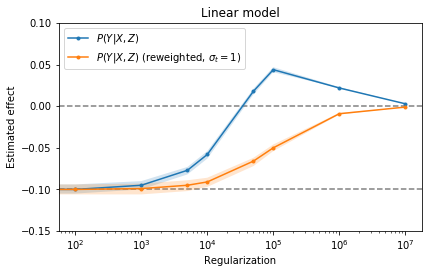

In [459]:
plt.subplots(figsize=(6, 3.5), gridspec_kw=dict(top=0.975, bottom=0.15, left=0.135, right=.975))
qlineplot(
    x='Regularization',
    hue='Method',
    y='Estimated effect',
    data=results[results['Method'].isin(subset_p_yxz)],
)
plt.axhline(y=-.1, color='k', ls='--', alpha=0.5, zorder=-1)
plt.axhline(y=0, color='k', ls='--', alpha=0.5, zorder=-1)
plt.ylim(-0.15, +0.1)
plt.xscale('log')
plt.legend(loc='upper left')
plt.title('Linear model')
plt.savefig('blog/linear_model_p_yxz_regularization.png', dpi=100)

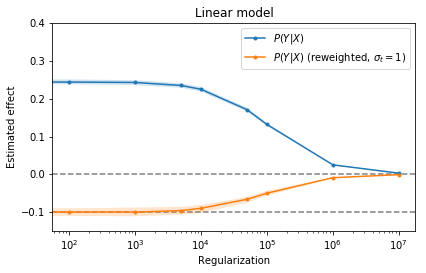

In [458]:
plt.subplots(figsize=(6, 3.5), gridspec_kw=dict(top=0.975, bottom=0.15, left=0.135, right=.975))
qlineplot(
    x='Regularization',
    hue='Method',
    y='Estimated effect',
    data=results[results['Method'].isin(subset_p_yx)],
)
plt.xscale('log')
plt.legend(loc='upper right')
plt.ylim(-0.15, 0.4)
plt.axhline(y=-.1, color='k', ls='--', alpha=0.5, zorder=-1)
plt.axhline(y=0, color='k', ls='--', alpha=0.5, zorder=-1)
plt.title('Linear model')
plt.savefig('blog/linear_model_p_yx_regularization.png', dpi=100)

# Simulated Drug Trial

Data set setup take from https://florianwilhelm.info/2017/04/causal_inference_propensity_score/

In [314]:
def simulate(size=100_000):
    def exp_recovery_time(df):
        return df.eval('exp(2 + 0.5 * sex + 0.03 * age + 2 * severity - 1 * medication)')

    def rvs_recovery_time(df):
        return scipy.stats.poisson.rvs(exp_recovery_time(df))
    
    def get_p_medication(df):
        u = df.eval('(1 / 3 * sex + 2 / 3 * severity - 0.8) / 0.15')
        return scipy.stats.norm(0, 1).cdf(u)

    return pd.DataFrame().assign(
        sex=lambda df: np.random.randint(0, 2, size=size),
        age=lambda df: scipy.stats.gamma.rvs(8, scale=4, size=size),
        severity=lambda df: scipy.stats.beta.rvs(3, 1.5, size=size),
        medication_p=lambda df: get_p_medication(df),
        medication=lambda df: np.random.binomial(n=1, p=df['medication_p']),
        recovery=lambda df: rvs_recovery_time(df),
        log_recovery=lambda df: df.eval('log(recovery)'),
        weight=lambda df: df.eval('medication / medication_p + (1 - medication) / (1 - medication_p)'),
        no_weight=lambda df: df.eval('1'),
    )

In [272]:
df = simulate()

In [266]:
features = ['sex', 'age', 'severity', 'medication']
target = 'log_recovery'

In [277]:
import itertools as it

In [416]:
@cached('.cache/blog_post_lgb_experiment.pickle')
def results_lgb():
    results = []
    for rep in loop_over(range(50)):
        df = simulate()
        for learning_rate, weight in loop_nest(
            list(
                it.product(
                    [0.75 ** e for e in range(1, 15)],
                    ['weight', 'no_weight'],
                )
            ),
            label=rep,
        ):
            est = lgb.LGBMRegressor(
                n_estimators=100, 
                learning_rate=learning_rate,
            )
            est.fit(df[features], df[target], sample_weight=df[weight])

            results.append(
                dict(
                    learning_rate=learning_rate,
                    weight=weight,
                    mad=abs(est.predict(df[features]) - df[target]).mean(),
                    ace=np.mean(
                        est.predict(df.assign(medication=1)[features]) - 
                        est.predict(df.assign(medication=0)[features])
                    ),
                )
            )

    return pd.DataFrame(results)

load cache .cache/blog_post_lgb_experiment.pickle


In [418]:
results_lgb['Inverse learning rate'] = 1 / results_lgb['learning_rate']
results_lgb['Weight'] = results_lgb['weight'].map(dict(weight='Reweighted', no_weight='Non-reweighted'))
results_lgb['Estimated effect'] = results_lgb['ace']
results_lgb['MAD'] = results_lgb['mad']

In [429]:
!open blog/lgb_effect_estimate.png

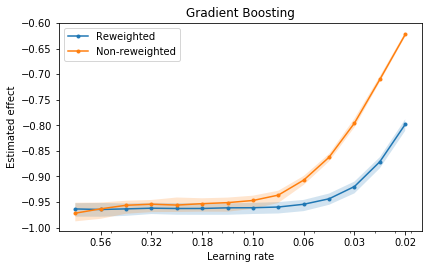

In [456]:
plt.subplots(figsize=(6, 3.5), gridspec_kw=dict(top=0.975, bottom=0.15, left=0.135, right=.975))
qlineplot(
    x='Inverse learning rate',
    hue='Weight',
    y='Estimated effect',
    ci=0.9,
    data=results_lgb,
)
plt.xscale('log')
learning_rates = np.sort(results_lgb['learning_rate'].unique())
learning_rates = learning_rates[::2]
plt.xticks(
    1.0 / learning_rates,
    ['{:.2f}'.format(lr) for lr in learning_rates]
)
plt.xlabel('Learning rate')
plt.title('Gradient boosting')
plt.savefig('blog/lgb_effect_estimate.png', dpi=100)

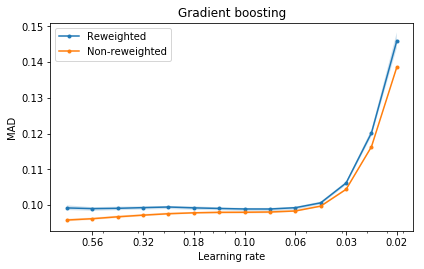

In [457]:
plt.subplots(figsize=(6, 3.5), gridspec_kw=dict(top=0.975, bottom=0.15, left=0.135, right=.975))
qlineplot(
    x='Inverse learning rate',
    hue='Weight',
    y='MAD',
    ci=0.9,
    data=results_lgb,
)
plt.xscale('log')
learning_rates = np.sort(results_lgb['learning_rate'].unique())
learning_rates = learning_rates[::2]
plt.xticks(
    1.0 / learning_rates,
    ['{:.2f}'.format(lr) for lr in learning_rates]
)
plt.xlabel('Learning rate')
plt.title('Gradient boosting')
plt.savefig('blog/lgb_mad.png', dpi=100)

# Linear model analytics

$$
\begin{align}
    z &\sim p(z) = \mathcal{N}(\mu_z, \sigma_z) 
\\
    x &\sim p(x|z) = \mathcal{N}(\mu_x + \alpha_{xz} z, \sigma_x)
\\
    y &\sim p(y|x, z) = \mathcal{N}(\mu_y + \alpha_{yx} x + \alpha_{yz} z, \sigma_y)
\end{align}
$$


$$
\begin{align}
    \mathbb{E} \left[ z \right] &= \mu_z
&
    \mathbb{E} \left[ x \right] &= \mu_x + \alpha_{xz} \mu_z
&
    \mathbb{E} \left[ y \right] &= 
        \mu_y 
        + \alpha_{yx} \mu_x + 
        (\alpha_{yx} \alpha_{xz} + \alpha_{yz}) \mu_z
\\
    \mathrm{cov} \left[ z, z \right] 
    &= \sigma_z^2 
&
    \mathrm{cov} \left[ x, z \right]
    &= \alpha_{xz} \sigma_z^2
&
    \mathrm{cov} \left[ y, z \right] 
    &= (\alpha_{yx} \alpha_{xz} + \alpha_{yz}) \sigma_z^2
\\
    &
&
    \mathrm{cov} \left[ x, x \right] 
    &= \sigma_{x}^2 + \alpha_{xz}^2 \sigma_z^2
&
    \mathrm{cov} \left[ y, x \right] 
    &= (\alpha_{yx} \alpha_{xz} + \alpha_{yz}) \alpha_{xz} \sigma_z^2 + \alpha_{yx} \sigma_x^2
\\
    &
&
    &
&
    \mathrm{cov} \left[ y, y \right]
    &= (\alpha_{yx} \alpha_{xz} + \alpha_{yz})^2 \sigma_z^2
    + \alpha_{yx}^2 \sigma_{x}^2
    + \sigma_y^2
\end{align}
$$

For simplicity, assume $\mu_y = 0$ and fit the linear model

$$
\begin{align}
    \hat{y} &= \beta_{yx} x + \beta_{yz} z
\end{align}
$$

The loss function is given by

$$
\begin{align}
    \mathcal{L} 
    &= \frac{1}{2} \langle (y - \hat{y})^2 \rangle 
    + \frac{1}{2} \lambda \beta_{yx}^2
    + \frac{1}{2} \lambda \beta_{yz}^2
\end{align}
$$

Setting the derivatives with respect to the parameters equal to zero yields

$$
\begin{align}
    \langle yx \rangle  
    &= \beta_{yx} (\lambda + \langle xx \rangle) + \beta_{yz} \langle zx \rangle
\\
    \langle yz \rangle  
    &= \beta_{yx} \langle xz \rangle + \beta_{yz} (\lambda + \langle zz \rangle)
\end{align}
$$

The coefficients are given by:

$$
\begin{align}
    \beta_{yx} &=
    \frac{
        \langle yx \rangle (\lambda + \langle zz \rangle) - \langle yz \rangle \langle zx \rangle
    }{
        (\lambda + \langle xx \rangle) (\lambda + \langle zz \rangle) 
        - \langle xz \rangle \langle zx \rangle
    }
\\
    \beta_{yz} &=
    \frac{
        \langle yx \rangle  \langle xz \rangle - \langle yz \rangle  (\lambda + \langle xx \rangle)
    }{
        \langle zx \rangle \langle xz \rangle - 
        (\lambda + \langle zz \rangle) (\lambda + \langle xx \rangle)
    }
\end{align}
$$

In [475]:
@define 
def _(render=True):
    mu_x, mu_y, mu_z = sp.symbols('mu_x, mu_y, mu_z')
    sigma_x, sigma_y, sigma_z = sp.symbols('sigma_x, sigma_y, sigma_z')
    alpha_xz, alpha_yx, alpha_yz = sp.symbols('alpha_xz, alpha_yx, alpha_yz')
    beta_yx, beta_yz, lam = sp.symbols('beta_yx, beta_yz, lambda')
    
    mu_y = 0
    mu_z = 0
    mu_x = 0
    
    #lam = 0
    
    mean_z = mu_z
    mean_x = mu_x + alpha_xz * mean_z
    mean_y = mu_y + alpha_yx * mean_x + alpha_yz * mean_z
    
    cov_zz = sigma_z ** 2
    cov_zx = alpha_xz * sigma_z ** 2
    cov_zy = (alpha_yx * alpha_xz + alpha_yz) * sigma_z ** 2

    cov_xx = sigma_x ** 2 + alpha_xz ** 2 * sigma_z ** 2
    cov_xy = (
        (alpha_yx * alpha_xz + alpha_yz) * alpha_xz * sigma_z ** 2 +
        alpha_yx * sigma_x ** 2
    )

    cov_yy = (
        ((alpha_yx * alpha_xz + alpha_yz) * sigma_z) ** 2
        + (alpha_yx * sigma_x) ** 2
        + sigma_y ** 2
    )
    
    mean_yx = mean_y * mean_x + cov_xy
    mean_yz = mean_y * mean_z + cov_zy
    mean_xz = mean_x * mean_z + cov_zx
    mean_zz = mean_z * mean_z + cov_zz
    mean_xx = mean_x * mean_x + cov_xx
    mean_yy = mean_y * mean_y + cov_yy
    
    beta_yx = sp.simplify(
        (mean_yx * (lam + mean_zz) - mean_yz * mean_xz) 
        / ((lam + mean_xx) * (lam + mean_zz) - mean_xz * mean_xz)
    )
    
    beta_yz = sp.simplify(
        (mean_yx * mean_xz - mean_yz * (lam + mean_xx)) 
        / (mean_xz * mean_xz - (lam + mean_zz) * (lam + mean_xx))
    )
    
    ratio = sp.simplify(beta_yx / beta_yz)
    
    if render:
        source = [
            r'$$'
            r'\begin{align}',
            r'\beta_{yx} &= ' + sp.latex(beta_yx),
            r'\\\\',
            r'\frac{\beta_{yx}}{\beta_{yz}} &= ' + sp.latex(ratio),
            r'\end{align}',
            '$$',
        ]
        
        display_markdown(Markdown('\n'.join(source)))
    
    else:
        print('beta_yx')
        print(sp.latex(beta_yx))
        print()
        print('beta_yx / beta_yz')
        print(sp.latex(ratio))

$$\begin{align}
\beta_{yx} &= \frac{\alpha_{xz} \sigma_{z}^{4} \left(\alpha_{xz} \alpha_{yx} + \alpha_{yz}\right) - \left(\lambda + \sigma_{z}^{2}\right) \left(\alpha_{xz} \sigma_{z}^{2} \left(\alpha_{xz} \alpha_{yx} + \alpha_{yz}\right) + \alpha_{yx} \sigma_{x}^{2}\right)}{\alpha_{xz}^{2} \sigma_{z}^{4} - \left(\lambda + \sigma_{z}^{2}\right) \left(\alpha_{xz}^{2} \sigma_{z}^{2} + \lambda + \sigma_{x}^{2}\right)}
\\\\
\frac{\beta_{yx}}{\beta_{yz}} &= \frac{\alpha_{xz}^{2} \alpha_{yx} \lambda \sigma_{z}^{2} + \alpha_{xz} \alpha_{yz} \lambda \sigma_{z}^{2} + \alpha_{yx} \lambda \sigma_{x}^{2} + \alpha_{yx} \sigma_{x}^{2} \sigma_{z}^{2}}{\sigma_{z}^{2} \left(\alpha_{xz} \alpha_{yx} \lambda + \alpha_{yz} \lambda + \alpha_{yz} \sigma_{x}^{2}\right)}
\end{align}
$$

For $\mu_x = 0, \mu_y = 0, \mu_z = 0$:

$$
\begin{align}
    \beta_{yx} &= 
    \frac{
        \alpha_{yx}
        + \frac{\lambda}{\sigma_x^2} \alpha_{xz} \left( \alpha_{yz} + \alpha_{xz} \alpha_{yx} \right)
        + \frac{\lambda}{\sigma_z^2} \alpha_{yx}
    }{
        \frac{\lambda}{\sigma_x^2} \alpha_{xz}^{2}
        + \left(1 + \frac{\lambda}{\sigma_z^2}\right)\left(1 + \frac{\lambda}{\sigma_x^2}\right)
    }
\\
    \beta_{yz} &=
    \frac{
        \alpha_{yz}
        + \frac{\lambda}{\sigma_x^2} ( \alpha_{xz} \alpha_{yx} + \alpha_{yz})
    }{
        \frac{\lambda}{\sigma_x^2} \alpha_{xz}^{2}
        + \left(1 + \frac{\lambda}{\sigma_z^2}\right)\left(1 + \frac{\lambda}{\sigma_x^2}\right)
    }
\end{align}
$$

Multiple regimes:

- $\lambda \ll \sigma_x^2, \sigma_z^2$: regularization is not important
- $\lambda \gg \sigma_x^2, \sigma_z^2$ and $\sigma_z^2 \gg \sigma_x^2$: regularization is important, variation in $z$ is much higher than $x$.
- $\lambda \gg \sigma_x^2, \sigma_z^2$ and $\sigma_x^2 \gg \sigma_z^2$: regularization is important, variation in $x$ is much higher than $z$.

Regime I:

$$
\begin{align}
    \beta_{yx} &\approx \alpha_{yx}
\\
    \beta_{yz} &\approx \alpha_{yz}
\end{align}
$$

Regime II:

$$
\begin{align}
    \beta_{yx} &\approx \frac{1}{1 + \alpha_{xz}^{-2}} 
        \left( \alpha_{yz} + \alpha_{xz} \alpha_{yx} \right)
\\
    \beta_{yz} &\approx \left( 1 - \frac{1}{1 + \alpha_{xz}^{-2}} \right)
        \left( \alpha_{xz} \alpha_{yx} + \alpha_{yz} \right)
\end{align}
$$

Regime III:

$$
\begin{align}
    \beta_{yx} &\approx \alpha_{yx}
\\
    \beta_{yz} &\approx 0
\end{align}
$$

Reweighted (setting $\alpha_{xz} = 0$ + fixing the variance):

$$
\begin{align}
    \beta_{yx} &= \frac{\alpha_{yx}}{\left(1 + \frac{\lambda}{\sigma_x^2}\right)}
\\
    \beta_{yz} &= \frac{\alpha_{yz}}{\left(1 + \frac{\lambda}{\sigma_z^2}\right)}
\end{align}
$$